## Use Case: Rrecommendation System

Es gibt zwei/drei Arten von Recommendern: 

* content based basierend auf Items, die der User mag/nicht mag
* user based basiernend auf ähnlichen Usern

[https://www5.in.tum.de/lehre/seminare/datamining/ss17/paper_pres/18_collab_filtering/collaborativeFiltering.pdf]

Wir verwenden hier heute die zweite Variante: user based.
Collaborative Filtering Algorithmen erhalten als Input eine
User-Item Rating Matrix und geben als Output entweder eine
Vorhersage, wie ein User ein bestimmtes Item bewerten w  ̈urde
oder eine Lister der besten n Items


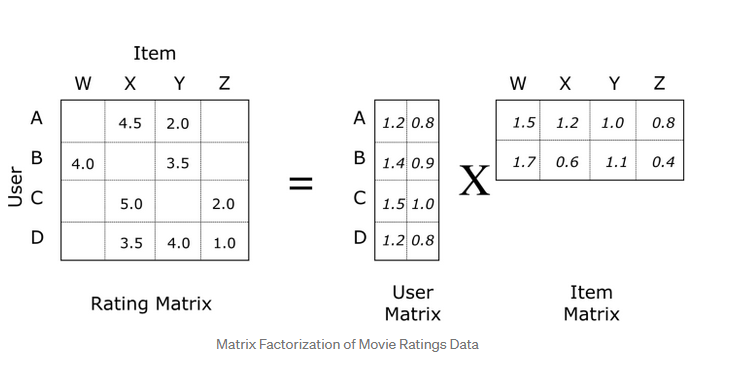

In [ ]:
# Befehle, die mit einem Ausrufezeichen starten, werden über das Terminal 
# ausgeführt und nicht als Python-Code

# Herunterladen und entpacken von Spark
# !wget -q https://dlcdn.apache.org/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
# !tar -xzvf spark-3.2.0-bin-hadoop3.2.tgz

# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64/"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"

# !pip install -q findspark


# import findspark
# findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkContext

spark = SparkSession.builder\
        .master("local")\
        .appName("ToyExample")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [ ]:
import pyspark.sql.functions as f 

ratings = (
    spark.read.csv(
        path="./data/ml-latest-small/ratings.csv",
        sep=',',
        header=True,
    quote='"',
    schema="userId INT, movieId INT, rating DOUBLE, timestamp INT"
    )
    .withColumn("timestamp", f.to_timestamp(f.from_unixtime("timestamp")))
    .cache() # this operations speeds computations up, it is telling to perform and hold operations in-memory and not released back.
)


Zunächst können wir uns noch zwei eigene Datensätze daraus erstellen

In [ ]:
ratings.summary().show()

In [ ]:
from pyspark.ml.recommendation import ALS

The arguments of the ALS class are:

```
class pyspark.ml.recommendation.ALS(
    rank=10,
    maxIter=10,
    regParam=0.1,
    numUserBlocks=10,
    numItemBlocks=10,
    implicitPrefs=False,
    alpha=1.0,
    userCol="user",
    itemCol="item",
    seed=None,
    ratingCol="rating",
    nonnegative=False,
    checkpointInterval=10,
    intermediateStorageLevel="MEMORY_AND_DISK",
    finalStorageLevel="MEMORY_AND_DISK",
    coldStartStrategy="nan",
)
```

rank, maxIter und regParam sind hierbei drei Hyperparameter. Hyperparameter sind Parameter, die nicht durch das Modell berechnet werden, sondern die von uns vorgegeben werden müssen. Da man hier nicht weiß was die besten Werte sind, muss man das durch "Trial and Error" mit System herausfinden.

* maxIter: the maximum number of iterations to run (defaults to 10)
* rank: the number of latent factors in the model (defaults to 10)
* regParam: the regularization parameter in ALS (defaults to 1.0)

Das Modell ist sehr schnell erstellt

In [ ]:
als = ALS(
        userCol="userId",
        itemCol="movieId",
        ratingCol="rating"
    )

model = als.fit(ratings)

In [ ]:
type(model)

In [ ]:
predictions = model.transform(ratings)

In [ ]:
type(predictions)

In [ ]:
predictions.show()

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
evaluator = RegressionEvaluator(
    metricName="rmse", labelCol="rating", predictionCol="prediction"
)

type(evaluator)

In [ ]:
rmse = evaluator.evaluate(predictions)

In [ ]:
rmse

### Model Fine tuning
Nun testen wir, ob wir unser Modell verbessern können. Daher teilen wir unseren Datensatz in zwei Teile auf, den Trainings-Teil und den Test-Teil.

In [ ]:
train_data, test_data = ratings.select(["userId", "movieId", "rating"]).randomSplit([8.0, 2.0])

In [ ]:
train_data.summary().show()

In [ ]:
model = als.fit(train_data)

In [ ]:
train_pred = model.transform(train_data)

In [ ]:
train_pred.show(10, False)

In [ ]:
train_rmse = evaluator.evaluate(train_pred)

In [ ]:
train_rmse

In [ ]:
test_pred = model.transform(test_data)

In [ ]:
test_pred.show(10, False)

In [ ]:
test_rmse = evaluator.evaluate(test_pred)
test_rmse

Wir bekommen nan zurück. Dies liegt daran, dass unser Modell nicht für alle User immer Werte vorhersagen konnte.

In [ ]:
from pyspark.sql.functions import isnan, when, count, col
import pyspark.sql.functions as f
test_pred.select([f.count(f.when(f.isnan(c), c)).alias(c) for c in test_pred.columns]).show()

In [ ]:
test_rmse = evaluator.evaluate(test_pred.na.drop())
test_rmse

Trainings RMSE und Test RMSE liegen relativ weit auseinander und der Trainings RMSE ist besser --> wir overfitten vermutlich und können und schauen, ob wir unser Modell noch verbessern können

In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder # here we are going to use hyperparameter tuning

parameter_grid = (
    ParamGridBuilder()
    .addGrid(als.rank, [1, 5, 10]) # parameter rank is going to traverse to 1 , 5, 10
    .addGrid(als.maxIter, [20])
    .addGrid(als.regParam, [0.5, 2 ])
    .build() # to finally build your parameters list up.
)

In [ ]:
type(parameter_grid)

In [ ]:
parameter_grid

In [ ]:
# For the cross validation part:

crossvalidator = CrossValidator(
    estimator=als,
    estimatorParamMaps=parameter_grid,
    evaluator=evaluator,
    numFolds=2 # how many times this is going to run or how many folds is going to be create from the data.
)

crossval_model = crossvalidator.fit(train_data)
test_predictions = crossval_model.transform(test_data)

In [ ]:
rmse = evaluator.evaluate(test_predictions.na.drop())
rmse

Wir sehen, dass wir sogar schlechter werden! Das kann leider vorkommen. In unserem Fall liegt es vermutlich daran, dass wir unseren Hyperparameterraum falsch/zu klein gewählt haben. Normalerweise macht man das ParameterGrid größer.

Hier kann gerne noch etwas ausprobiert werden, ob das Modell verbessert werden kann. Wir lassen es hier vorerst gut sein und wollen nun Vorschläge für User machen.

In [ ]:
model = crossval_model.bestModel

Für die Empfehlung von Filmen, müssen wir noch den Movies Datensatz einlesen und etwas verarbeiten. 

In [ ]:
movies = (
    spark.read.csv(
        path="movies.csv",
        sep=",",
        header=True,
        quote='"',
        schema="movieId INT, title STRING, genres STRING"
    )
    .withColumn("release_year", f.regexp_extract(f.col("title"), "\s?\((\d{4})\)", 1))
    .withColumn("title", f.regexp_replace(f.col("title"), "\s?\((\d{4})\)", ""))
    .withColumn("genres", f.split(f.col("genres"), "\|"))
    .cache()
)

movies.show()

In [ ]:
movies.describe().show()

# Empfehlungen

Wir werden zwei Methoden verwenden, um Empfehlungen abzugeben

## Methode 1
Berechne für alle Filme und alle User Empfehlungen im Vorhinen und filtere dann einfach nach den benötigten Usern. 

Dazu kann die Methode recommendForAllUsers() verwendet werden, der man sagen muss wie viele Vorschläge pro User gemacht werden sollen

In [ ]:
USER_ID = 15


In [ ]:
rec_all_users = model.recommendForAllUsers(5).cache()
rec_all_users.show(10, False)

In [ ]:
recommendations_for_user1 = (
    rec_all_users.filter(f"userId == {USER_ID}")
    # Use explode to convert the array to rows with structs
    .withColumn("rec", f.explode("recommendations"))
    # Select the columns we want from the resulting struct
    .select(
        "userId",
        f.col("rec").movieId.alias("movieId"),
        f.col("rec").rating.alias("rating"),
    )
    # Join movies dataframe and selct only the columns we want
    .join(movies, "movieId")
    .orderBy("rating", ascending=False)
    .select("movieId", "title", "release_year")
)

recommendations_for_user1.show(5, False)

## Methode 2

Ähnlich zu Methode 1, aber nicht für alle User, gibt es die Methode recommendForUserSubset(numItems).

In [ ]:
USER_ID = 300
subset = ratings.filter(ratings["userId"] == USER_ID).select("userId")
rec_subset = model.recommendForUserSubset(subset, 5)
rec_subset.show(1, False)

In [ ]:
recommendations_for_user2 = (
    rec_subset
    # Use explode to convert the array to rows with structs
    .withColumn("rec", f.explode("recommendations"))
    # Select the columns we want from the resulting struct
    .select(
        "userId",
        f.col("rec").movieId.alias("movieId"),
        f.col("rec").rating.alias("rating"),
    )
    # Join movies dataframe and selct only the columns we want
    .join(movies, "movieId")
    .orderBy("rating", ascending=False)
    .select("movieId", "title", "release_year", "rating")
)

recommendations_for_user2.show(5, False)